# Laboratorium Nr 3
Zadaniem dla zespołów jest przeprowadzenie analizy danych i próba odpowiedzi na pytanie:„Czy na podstawie danych z ostatnich 24 lat można wyciągnąć wnioski na temat ocieplenia klimatu?”

In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv
import pyodbc
from sqlalchemy import create_engine, text
from scipy.stats import linregress

## Przygotowanie danych

In [10]:
load_dotenv()

True

In [11]:

login = os.getenv("LOGIN")
password = os.getenv("PASSWORD")
db_host = os.getenv("DB_HOST")
port = os.getenv("PORT")
database = os.getenv("DB_NAME")

In [12]:
conn_str = (
    f"mssql+pyodbc://{login}:{password}@{db_host},{port}/{database}"
    "?driver=ODBC+Driver+17+for+SQL+Server"
)


In [13]:
engine = create_engine(conn_str)

In [20]:
query_depesze = text("""
        SELECT idstacji, Data, TemperaturaPowietrza, WysokoscOpadu, CisnienieNaPoziomieStacji
        FROM Synop.dbo.Depesze as depesze
        WHERE depesze.Data BETWEEN '2000-01-01' and '2025-01-01'
    """)



In [15]:
query_stacje = text("""
        SELECT IDStacji, Nazwa, Wojewodztwo
        FROM  Synop.dbo.Stacje as stacje
        WHERE stacje.Kraj = 'Poland'
    """)


In [21]:

with engine.connect() as conn:
    df_depesze = pd.read_sql(query_depesze, conn)


In [ ]:
#df_depesze.to_csv('depesze_output.csv', encoding='utf-8')

In [18]:

with engine.connect() as conn:
    df_stacje = pd.read_sql(query_stacje, conn)

In [26]:
df_merged = df_depesze.merge(df_stacje, left_on="idstacji", right_on="IDStacji", how="left")

In [29]:
df_merged = df_merged.drop(columns=["IDStacji", "idstacji"])

In [30]:
print(df_merged.head(5))


         Data  TemperaturaPowietrza  WysokoscOpadu  CisnienieNaPoziomieStacji  \
0  2000-04-13                   7.7            0.0                      980.2   
1  2000-04-13                   8.0            0.0                      980.5   
2  2000-04-13                   9.8            0.0                      988.1   
3  2000-04-13                  10.1            0.0                      974.9   
4  2000-04-13                  11.8            0.0                      982.1   

       Nazwa  Wojewodztwo  
0       Łódź      łódzkie  
1    Sulejów      łódzkie  
2  Kozienice  mazowieckie  
3     Lublin    lubelskie  
4    Włodawa    lubelskie  


In [31]:
print(df_merged.describe())

       TemperaturaPowietrza  WysokoscOpadu  CisnienieNaPoziomieStacji
count          1.270878e+07   1.270889e+07               1.270889e+07
mean           8.940766e+00   1.278610e-01               9.067828e+02
std            8.813644e+00   2.387944e+00               2.778723e+02
min           -9.820000e+01   0.000000e+00               0.000000e+00
25%            2.300000e+00   0.000000e+00               9.818000e+02
50%            8.700000e+00   0.000000e+00               9.955000e+02
75%            1.550000e+01   0.000000e+00               1.005900e+03
max            9.600000e+01   9.880000e+02               1.099900e+03


In [41]:
df = df_merged.copy()
df["Data"] = pd.to_datetime(df["Data"])
df["Rok"] = df["Data"].dt.year
df["Miesiąc"] = df["Data"].dt.month

In [42]:
df = df[df["TemperaturaPowietrza"].notnull()]

### Dodatkowe kolumny

In [43]:
def get_season(month):
    if month in [12, 1, 2]:
        return "Zima"
    elif month in [3, 4, 5]:
        return "Wiosna"
    elif month in [6, 7, 8]:
        return "Lato"
    else:
        return "Jesień"

df["Sezon"] = df["Miesiąc"].apply(get_season)

In [45]:
print(df.head(5))

        Data  TemperaturaPowietrza  WysokoscOpadu  CisnienieNaPoziomieStacji  \
0 2000-04-13                   7.7            0.0                      980.2   
1 2000-04-13                   8.0            0.0                      980.5   
2 2000-04-13                   9.8            0.0                      988.1   
3 2000-04-13                  10.1            0.0                      974.9   
4 2000-04-13                  11.8            0.0                      982.1   

       Nazwa  Wojewodztwo   Rok  Miesiąc   Sezon  
0       Łódź      łódzkie  2000        4  Wiosna  
1    Sulejów      łódzkie  2000        4  Wiosna  
2  Kozienice  mazowieckie  2000        4  Wiosna  
3     Lublin    lubelskie  2000        4  Wiosna  
4    Włodawa    lubelskie  2000        4  Wiosna  


### Agregacja

In [57]:
monthly_by_region = (
    df.groupby(["Rok", "Sezon"])["TemperaturaPowietrza"]
    .mean()
    .reset_index()
)


In [58]:
print(monthly_by_region.head(5))

    Rok   Sezon  TemperaturaPowietrza
0  2000  Jesień              9.990298
1  2000    Lato             16.670626
2  2000  Wiosna              9.783174
3  2000    Zima              0.898882
4  2001  Jesień              7.632755


## Wizualizacja

/tmp/ipykernel_13947/3955009953.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


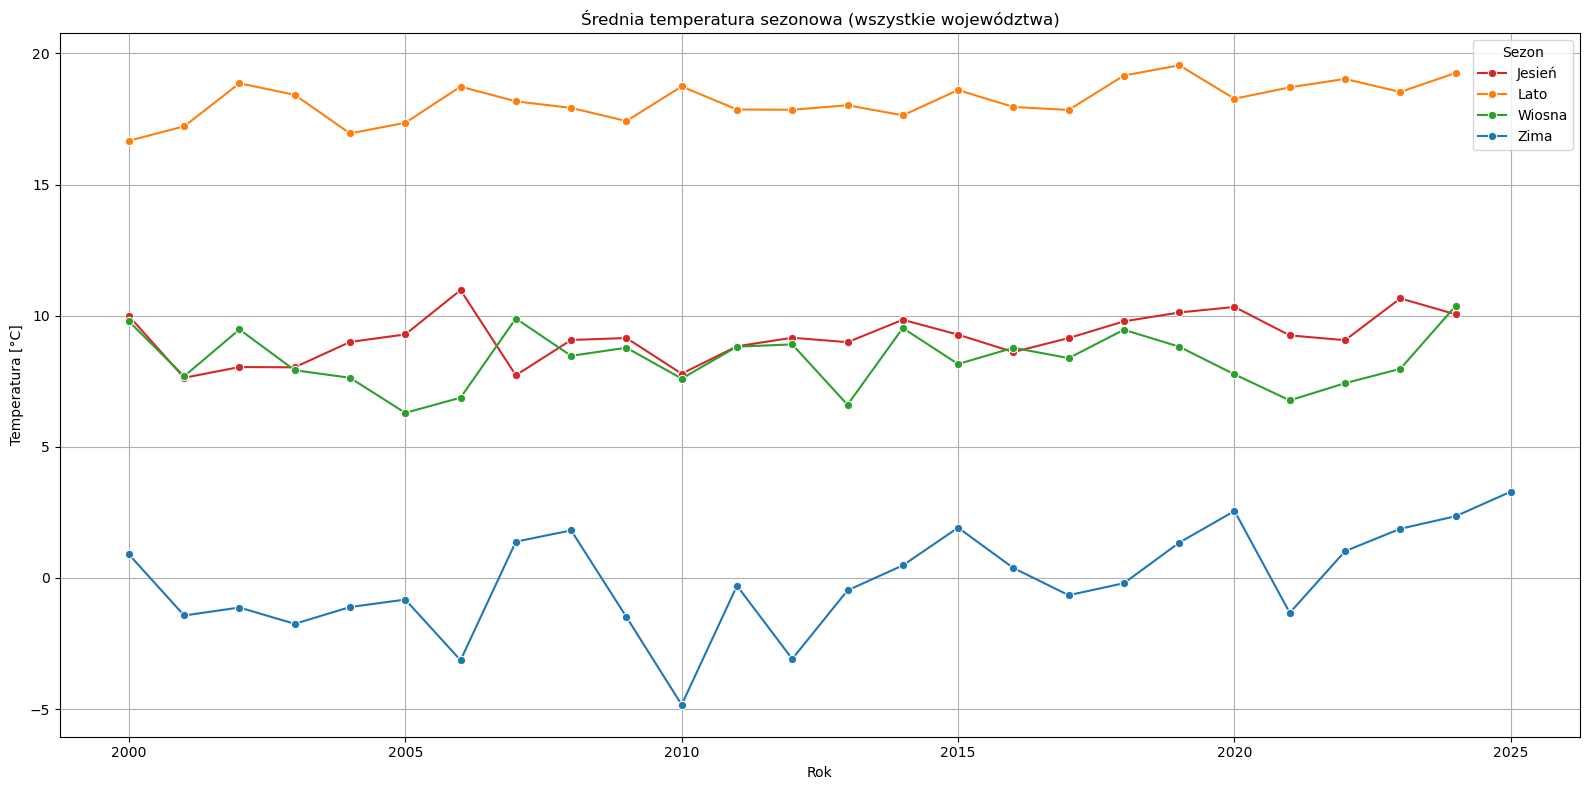

In [61]:
season_colors = {
    "Zima": "#1f77b4",   # Niebieski
    "Wiosna": "#2ca02c",   # Zielony
    "Lato": "#ff7f0e",   # Pomarańczowy
    "Jesień": "#d62728",   # Rdzawy czerwony
}

plt.figure(figsize=(16, 8))
sns.lineplot(
    data=monthly_by_region,
    x="Rok",
    y="TemperaturaPowietrza",
    hue="Sezon",
    ci=None,
    marker="o",
    palette=season_colors
)
plt.title("Średnia temperatura sezonowa (wszystkie województwa)")
plt.ylabel("Temperatura [°C]")
plt.xlabel("Rok")
plt.grid(True)
plt.legend(title="Sezon")
plt.tight_layout()
plt.show()